# Teacher's Assignment No. 13

***Author:*** *Ofir Paz* $\qquad$ ***Version:*** *20.04.2024* $\qquad$ ***Course:*** *22961 - Deep Learning*

Welcome to the third assignment of the course *Deep Learning*. \
In this assignment we will explore Pytorch's DataLoader, and use it to train a neural network for classification purposes. 

## Imports

First, we will import the required packages for this assignment.
- [pytorch](https://pytorch.org/) - One of the most fundemental and famous tensor handling library.
- [numpy](https://numpy.org) - The fundamental package for scientific computing with Python.
- [pandas](https://pandas.pydata.org) - Library to handle data in Python.
- [matplotlib](https://matplotlib.org) - Library to plot graphs in Python.

In [1]:
import torch  # pytorch.
import torch.nn as nn  # neural network module.
import torch.optim as optim  # optimization module.
import torch.nn.functional as F  # functional module.
import numpy as np  # numpy.
import torchvision.transforms as transforms  # image transformation module.
from torch.utils.data import DataLoader, Dataset  # data loader and dataset base class.
from torchmetrics import Accuracy  # accuracy metric.
import pandas as pd  # handling data.
import matplotlib.pyplot as plt  # plotting.
from typing import Literal  # type hinting.

## Diabetes Dataset

In this section, we will handle the pre processing of the provided *Diabetes dataset*. The Diabetes dataset is a csv file containing 442 different records for different patients holding information about the patient, and an additional column (Y) with the Diabetes' progression rate.

In [2]:
# Load the dataset with pandas.
data = pd.read_csv('diabetes.csv', sep='\t')

# Display the first 5 rows of the dataset.
data.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


We would like to divide the dataset to $10$ classes which represent the tenth precentile of the value of $Y$.

In [3]:
def get_labeled_data(data: pd.DataFrame, num_precentiles: int = 10) -> pd.DataFrame:
    # Copy the original dataset.
    labeled_data = data.copy()

    # Create the new column `Class` and initialize it with NaN.
    labeled_data['Class'] = np.NaN

    # Iterate over the percentiles.
    for klass in np.arange(num_precentiles):
        # Calculate the k-th percentile of the column 'Y'.
        percentile = data['Y'].quantile(klass / num_precentiles)

        # Label the matching class for all rows where 
        #  the value of 'Y' is greater or equal to the percentile.
        labeled_data.loc[(data['Y'] >= percentile).values, 'Class'] = klass

    return labeled_data

tenth_percentile_data = get_labeled_data(data, num_precentiles=10)

tenth_percentile_data.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y,Class
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151,5.0
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75,1.0
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141,5.0
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206,7.0
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135,4.0


Now we will create the wraper pytorch dataset to hold the labeled dataset.

In [4]:
class DiabetesDataset(Dataset):
    def __init__(self, data: pd.DataFrame, transform: transforms.Compose | None = None, 
                 drop_Y: bool = False):
        self.data = data
        self.transform = transform
        self.drop_Y = drop_Y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        x = row.drop('Class')
        if self.drop_Y:
            x = x.drop('Y')
        if self.transform:
            x = self.transform(x)
        y = row['Class']
        y = torch.tensor(y, dtype=torch.long)
        return x, y

Here we use pytorch's dataloader to create a data loader for the dataset and display a single mini-batch of data. 

In [5]:
BATCH_SIZE = 10
TRAIN_VAL_RATIO = 0.8

transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x.values.astype(np.float32))),
    # transforms.Lambda(lambda x: (x - x.mean()) / x.std()),
])

# Split the dataset into a training and a validation set.
train_data = tenth_percentile_data.sample(frac=TRAIN_VAL_RATIO, random_state=42)
val_data = tenth_percentile_data.drop(train_data.index)

# Create the datasets.
train_dataset_with_Y = DiabetesDataset(train_data, transform=transform)
val_dataset_with_Y = DiabetesDataset(val_data, transform=transform)

# Create the dataloaders.
train_loader_with_Y = DataLoader(train_dataset_with_Y, batch_size=BATCH_SIZE, shuffle=True)
val_loader_with_Y = DataLoader(val_dataset_with_Y, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
# Print a mini-batch.
for x, y in train_loader_with_Y:
    print(x.shape, x)  # 10 samples with 11 features each.
    print(y.shape, y)  # 10 labels.
    break

torch.Size([10, 11]) tensor([[ 55.0000,   1.0000,  23.0000,  94.6700, 190.0000, 137.6000,  38.0000,
           5.0000,   4.2767, 106.0000, 146.0000],
        [ 53.0000,   1.0000,  28.6000,  88.0000, 171.0000,  98.8000,  41.0000,
           4.0000,   5.0499,  99.0000, 265.0000],
        [ 26.0000,   2.0000,  30.3000,  89.0000, 218.0000, 152.2000,  31.0000,
           7.0000,   5.1591,  82.0000, 137.0000],
        [ 46.0000,   2.0000,  23.8000,  97.0000, 224.0000, 139.2000,  42.0000,
           5.0000,   5.3660,  81.0000, 209.0000],
        [ 52.0000,   1.0000,  24.5000,  90.0000, 198.0000, 129.0000,  29.0000,
           7.0000,   5.2983,  86.0000, 233.0000],
        [ 54.0000,   2.0000,  27.3000, 100.0000, 200.0000, 144.0000,  33.0000,
           6.0000,   4.7449,  76.0000, 235.0000],
        [ 71.0000,   2.0000,  27.0000,  93.3300, 269.0000, 190.2000,  41.0000,
           6.5600,   5.2417,  93.0000, 131.0000],
        [ 49.0000,   1.0000,  25.6000,  76.0000, 161.0000,  99.8000,  51.000

## The Neural Network

In this section, we will design the architecture for the *Neural Network* (NN) to classify the tenth precentile of the Diabetes' progression, and train it. We will use the data loader defined above and `torch.nn` to create the architecture. Since we have a small dataset with only $11$ features, we will simply create a fully connected NN with a small number of layers and neurons.

In [7]:
class DiabetesPrecentileClassifer(nn.Module):
    def __init__(self, input_size: int = 11, num_classes: int = 10):
        super(DiabetesPrecentileClassifer, self).__init__()
        self.fc1 = nn.Linear(input_size, 15)
        self.fc2 = nn.Linear(15, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc4 = nn.Linear(30, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

The next code block introduces the train loop function. The train loop iterates over the dataloader and uses the optimizer and criterion to update the NN weights in the gradient decent algorithm.

In [8]:
def train(model: nn.Module, data_loader: DataLoader, num_epochs: int = 30, lr: float = 0.001, 
          wd: float = 0., loss_func: Literal['log', 'MSE'] = 'log', try_cuda: bool = False,
          print_cost: bool = False, print_stride: int = 1) -> list[float]:
    """
    Train the model.
    
    :param model: The model to train.
    :param data_loader: The data loader.
    :param num_epochs: The number of epochs.
    :param lr: The learning rate.
    :param wd: The weight decay.
    :param loss_func: The loss function to use can either be `log` or `MSE`.
    :param try_cuda: A flag indicating if the model should be trained on the GPU.
    :param print_cost: A flag indicating if the cost should be printed.
    :param print_stride: The stride for printing the cost.
    :return: The total cost of each epoch.
    """
    
    costs: list[float] = []
    
    use_cuda = try_cuda and torch.cuda.is_available()
    if use_cuda:
        print("Using CUDA for traininig.")
        model = model.cuda()

    # Create the optimizer and criterion.
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss() if loss_func == 'log' else nn.MSELoss()  # log or MSE.

    for epoch in range(num_epochs):
        running_loss = 0.
        for x, y in data_loader:
            if use_cuda:
                x, y = x.cuda(), y.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_hat = model(x)

            if loss_func == 'MSE':
                y = y.float()
                y_hat = y_hat.squeeze()
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            # Calc loss
            lloss = loss.item()
            running_loss += lloss * x.size(0)

        epoch_loss = running_loss / (len(data_loader) * BATCH_SIZE)
        costs.append(epoch_loss)
            
        if print_cost and (epoch % print_stride == 0 or epoch == num_epochs - 1):
            print(f"\r[epoch: {epoch+1}/{num_epochs}] Total Loss: {epoch_loss}")

    return costs

In [9]:
# Train the network.
classifer_with_Y = DiabetesPrecentileClassifer()

train(classifer_with_Y, train_loader_with_Y, num_epochs=150, lr=0.001,
      print_cost=True, print_stride=20)
print("\nREDUCED LEARNING RATE TO 0.0001\n")
train(classifer_with_Y, train_loader_with_Y, num_epochs=75, lr=0.0001,
      print_cost=True, print_stride=20);

[epoch: 1/150] Total Loss: 2.873996202150981
[epoch: 21/150] Total Loss: 0.7551723611023691
[epoch: 41/150] Total Loss: 0.6652364141411251
[epoch: 61/150] Total Loss: 0.6551922620998488
[epoch: 81/150] Total Loss: 0.5652710263927777
[epoch: 101/150] Total Loss: 0.5620862090753185
[epoch: 121/150] Total Loss: 0.5066907885173957
[epoch: 141/150] Total Loss: 0.4674604301651319
[epoch: 150/150] Total Loss: 0.5143173951241705

REDUCED LEARNING RATE TO 0.0001

[epoch: 1/75] Total Loss: 0.4257424954738882
[epoch: 21/75] Total Loss: 0.38944191936817435
[epoch: 41/75] Total Loss: 0.38571395302812256
[epoch: 61/75] Total Loss: 0.38490768290228317
[epoch: 75/75] Total Loss: 0.3756044932537609


In [10]:
def evaluate(model: nn.Module, data_loader: DataLoader) -> float:
    """
    Evaluate the model.
    
    :param model: The model.
    :param data_loader: The data loader.
    :return: The accuracy
    """
    accuracy_module = Accuracy(task="multiclass", num_classes=model.fc4.out_features)
    all_prob_preditions, all_labels = torch.tensor([]), torch.tensor([])

    with torch.no_grad():
        for inputs, labels in data_loader:
            prob_preditions = model(inputs)
            all_prob_preditions = torch.cat((all_prob_preditions, prob_preditions))
            all_labels = torch.cat((all_labels, labels))

    accuracy = accuracy_module(all_prob_preditions.argmax(dim=-1), all_labels)
    
    return accuracy

In [11]:
# Evaluate the network.
print(f"Accuracy: {evaluate(classifer_with_Y, train_loader_with_Y):.2%}")
print(f"Accuracy: {evaluate(classifer_with_Y, val_loader_with_Y):.2%}")

Accuracy: 82.49%
Accuracy: 67.05%


In [12]:
# Create the datasets without the `Y` values.
train_dataset_without_Y = DiabetesDataset(train_data, transform=transform, drop_Y=True)
val_dataset_without_Y = DiabetesDataset(val_data, transform=transform, drop_Y=True)

# Create the dataloaders without the `Y` values.
train_loader_without_Y = DataLoader(train_dataset_without_Y, batch_size=BATCH_SIZE, shuffle=True)
val_loader_without_Y = DataLoader(val_dataset_without_Y, batch_size=BATCH_SIZE, shuffle=False)

# Create the model without the `Y` values.
classifer_without_Y = DiabetesPrecentileClassifer(input_size=10)

train(classifer_without_Y, train_loader_without_Y, num_epochs=150, lr=0.001,
      print_cost=True, print_stride=20)
print("\nREDUCED LEARNING RATE TO 0.0001\n")
train(classifer_without_Y, train_loader_without_Y, num_epochs=75, lr=0.0001,
      print_cost=True, print_stride=20);

[epoch: 1/150] Total Loss: 2.4558302376005385
[epoch: 21/150] Total Loss: 1.9178077313635085
[epoch: 41/150] Total Loss: 1.8125113877985213
[epoch: 61/150] Total Loss: 1.7671432495117188
[epoch: 81/150] Total Loss: 1.660578227043152
[epoch: 101/150] Total Loss: 1.5875573853651683
[epoch: 121/150] Total Loss: 1.5395028074582418
[epoch: 141/150] Total Loss: 1.4479724413818784
[epoch: 150/150] Total Loss: 1.458085294895702

REDUCED LEARNING RATE TO 0.0001

[epoch: 1/75] Total Loss: 1.3553193463219537
[epoch: 21/75] Total Loss: 1.3223698907428318
[epoch: 41/75] Total Loss: 1.306242338485188
[epoch: 61/75] Total Loss: 1.2972087423006693
[epoch: 75/75] Total Loss: 1.2914809743563334


In [13]:
print(f"Accuracy: {evaluate(classifer_without_Y, train_loader_without_Y):.2%}")
print(f"Accuracy: {evaluate(classifer_without_Y, val_loader_without_Y):.2%}")

Accuracy: 52.26%
Accuracy: 19.32%


We trained two neural networks on the dataset to predict the classes. One of the neural networks had the `Y` values as a feature, and the other one didn't. The classes were directly computed through the `Y` values, thus it is expected that the first NN will perform better.

In the next section, we will divide the dataset to $100$ classes instead of $10$ and train the networks again on this new dataset. The classes will now represent the hundredth precentile.

In [14]:
# Change dataset to hundredth percentile instead of tenth precentile.
hundredth_percentile_data = get_labeled_data(data, num_precentiles=100)

# Split the dataset into a training and a validation set.
train_hundredth_precentile = hundredth_percentile_data.sample(frac=TRAIN_VAL_RATIO, random_state=42)
val_hundredth_precentile = hundredth_percentile_data.drop(train_data.index)

In [15]:
# Train network with `Y` values.

# Create the datasets.
train_dataset100_with_Y = DiabetesDataset(train_hundredth_precentile, transform=transform)
val_dataset100_with_Y = DiabetesDataset(val_hundredth_precentile, transform=transform)

# Create the dataloaders.
train_loader100_with_Y = DataLoader(train_dataset100_with_Y, batch_size=BATCH_SIZE, shuffle=True)
val_loader100_with_Y = DataLoader(val_dataset100_with_Y, batch_size=BATCH_SIZE, shuffle=False)

# Create the neural network.
classifer100_with_Y = DiabetesPrecentileClassifer(input_size=11, num_classes=100)

# Train the network.
train(classifer100_with_Y, train_loader_with_Y, num_epochs=150, lr=0.001,
      print_cost=True, print_stride=20)
print("\nREDUCED LEARNING RATE TO 0.0001\n")
train(classifer100_with_Y, train_loader_with_Y, num_epochs=75, lr=0.0001,
      print_cost=True, print_stride=20);

# Evaluate the network.
print(f"Accuracy: {evaluate(classifer100_with_Y, train_loader100_with_Y):.2%}")
print(f"Accuracy: {evaluate(classifer100_with_Y, val_loader100_with_Y):.2%}")

[epoch: 1/150] Total Loss: 5.2099314570426944
[epoch: 21/150] Total Loss: 0.8114013034436438
[epoch: 41/150] Total Loss: 0.7122957885265351
[epoch: 61/150] Total Loss: 0.6551700068844689
[epoch: 81/150] Total Loss: 0.6347943844066726
[epoch: 101/150] Total Loss: 0.6074779878060023
[epoch: 121/150] Total Loss: 0.5805866906212436
[epoch: 141/150] Total Loss: 0.5189092259440157
[epoch: 150/150] Total Loss: 0.5086257276435693

REDUCED LEARNING RATE TO 0.0001

[epoch: 1/75] Total Loss: 0.45550413736038736
[epoch: 21/75] Total Loss: 0.4403919524616665
[epoch: 41/75] Total Loss: 0.4334119126200676
[epoch: 61/75] Total Loss: 0.4286404980553521
[epoch: 75/75] Total Loss: 0.4212534281114737
Accuracy: 1.13%
Accuracy: 1.14%


In [16]:
# Train network without `Y` values.

# Create the datasets.
train_dataset100_without_Y = DiabetesDataset(train_hundredth_precentile, transform=transform, drop_Y=True)
val_dataset100_without_Y = DiabetesDataset(val_hundredth_precentile, transform=transform, drop_Y=True)

# Create the dataloaders.
train_loader100_without_Y = DataLoader(train_dataset100_without_Y, batch_size=BATCH_SIZE, shuffle=True)
val_loader100_without_Y = DataLoader(val_dataset100_without_Y, batch_size=BATCH_SIZE, shuffle=False)

# Create the neural network.
classifer100_without_Y = DiabetesPrecentileClassifer(input_size=10, num_classes=100)

# Train the network.
train(classifer100_without_Y, train_loader100_without_Y, num_epochs=150, lr=0.001,
      print_cost=True, print_stride=20)
print("\nREDUCED LEARNING RATE TO 0.0001\n")
train(classifer100_without_Y, train_loader100_without_Y, num_epochs=75, lr=0.0001,
      print_cost=True, print_stride=20)

# Evaluate the network.
print(f"Accuracy: {evaluate(classifer100_without_Y, train_loader100_without_Y):.2%}")
print(f"Accuracy: {evaluate(classifer100_without_Y, val_loader100_without_Y):.2%}")

[epoch: 1/150] Total Loss: 5.487525765101115
[epoch: 21/150] Total Loss: 3.770982829729716
[epoch: 41/150] Total Loss: 3.371075839466519
[epoch: 61/150] Total Loss: 2.987810382578108
[epoch: 81/150] Total Loss: 2.575882848766115
[epoch: 101/150] Total Loss: 2.2734833406077493
[epoch: 121/150] Total Loss: 1.9971642090214623
[epoch: 141/150] Total Loss: 1.725299224588606
[epoch: 150/150] Total Loss: 1.6525369736883375

REDUCED LEARNING RATE TO 0.0001

[epoch: 1/75] Total Loss: 1.4956371002727085
[epoch: 21/75] Total Loss: 1.3792361434963014
[epoch: 41/75] Total Loss: 1.3478642731904984
[epoch: 61/75] Total Loss: 1.328977722591824
[epoch: 75/75] Total Loss: 1.3037893353237047
Accuracy: 64.69%
Accuracy: 0.00%


We experience much worse results, that is because the dataset is too small (around $4$ instances of each class) to successfully learn how to predict a class out of $100$ classes. It is preferable to use the tenth precentile as classes instead of the hundredth precentile, since the added accuracy in the `Y` prediction gained from the $100$ classes prediction is a lesser of a gain than the added overall accuracy of the $10$ classes prediction network.

In [17]:
# 5 POINTS BONNUS
# Train a regression network on the dataset.
# First, redfine the dataset to be a regression dataset.
class DiabetesRegressionDataset(Dataset):
    def __init__(self, data: pd.DataFrame, transform: transforms.Compose | None = None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        x = row.drop('Y')
        if self.transform:
            x = self.transform(x)
        y = row['Y']
        y = torch.tensor(y, dtype=torch.float32)
        return x, y

# Create a specific network architecture for regression.
class DiabetesRegressionModel(nn.Module):
    def __init__(self):
        super(DiabetesRegressionModel, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

Using CUDA for traininig.
[epoch: 1/300] Total Loss: 23614.38343290441
[epoch: 21/300] Total Loss: 3661.51876953125
[epoch: 41/300] Total Loss: 2869.50208984375
[epoch: 61/300] Total Loss: 2692.8055388327207
[epoch: 81/300] Total Loss: 2605.936144875919
[epoch: 101/300] Total Loss: 2497.112819967831
[epoch: 121/300] Total Loss: 2578.360021829044
[epoch: 141/300] Total Loss: 3108.028125
[epoch: 161/300] Total Loss: 2490.8186994485295
[epoch: 181/300] Total Loss: 2343.503718405331
[epoch: 201/300] Total Loss: 2293.7829032628674
[epoch: 221/300] Total Loss: 2359.3113861443017
[epoch: 241/300] Total Loss: 2210.9206430951285
[epoch: 261/300] Total Loss: 2169.8064970128676
[epoch: 281/300] Total Loss: 2159.011867532169
[epoch: 300/300] Total Loss: 2549.445388327206

REDUCED LEARNING RATE TO 0.0001

Using CUDA for traininig.
[epoch: 1/150] Total Loss: 2236.5238453584557
[epoch: 21/150] Total Loss: 2068.9676298253676
[epoch: 41/150] Total Loss: 2057.761062155331
[epoch: 61/150] Total Loss: 205

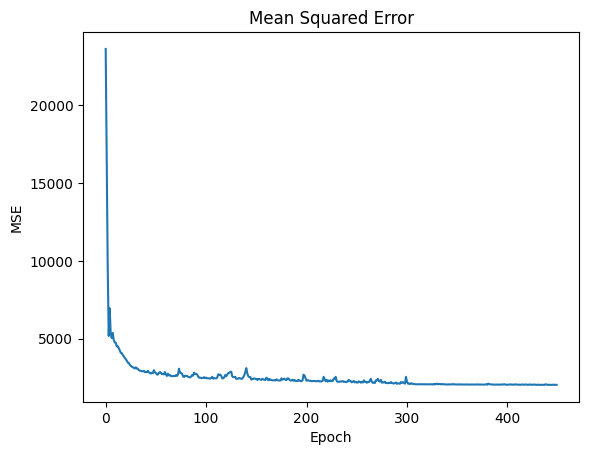

In [18]:
# Now, train the network the usual way.
# We change the output layer to have a single neuron and no activation function.
# We also change the loss function to be the mean squared error (MSE).
BATCH_SIZE = 85

# Split the dataset into a training and a validation set.
train_reg_data = data.sample(frac=TRAIN_VAL_RATIO, random_state=42)
val_reg_data = data.drop(train_data.index)

# Create the datasets.
train_dataset_regression = DiabetesRegressionDataset(train_reg_data, transform=transform)
val_dataset_regression = DiabetesRegressionDataset(val_reg_data, transform=transform)

# Create the dataloaders.
train_loader_regression = DataLoader(train_dataset_regression, batch_size=BATCH_SIZE, shuffle=True)
val_loader_regression = DataLoader(val_dataset_regression, batch_size=BATCH_SIZE, shuffle=False)

# Create the neural network.
classifer_regression = DiabetesRegressionModel()

# Train the network.
costs1 = train(classifer_regression, train_loader_regression, num_epochs=300, lr=0.001, wd=0.001,
               loss_func='MSE', try_cuda=True, print_cost=True, print_stride=20)
print("\nREDUCED LEARNING RATE TO 0.0001\n")
costs2 = train(classifer_regression, train_loader_regression, num_epochs=150, lr=0.0001, wd=0.001,
               loss_func='MSE', try_cuda=True, print_cost=True, print_stride=20)

# Evaluate the network.
regression_costs = np.array(costs1 + costs2)

plt.plot(regression_costs)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error')
plt.show()

In [19]:
# Evaluate the network.
X_train : np.ndarray = train_reg_data.drop('Y', axis=1).values
y_train : np.ndarray = train_reg_data['Y'].values  # type: ignore
X_val : np.ndarray = val_reg_data.drop('Y', axis=1).values
y_val : np.ndarray = val_reg_data['Y'].values  # type: ignore

with torch.no_grad():
    classifer_regression.cpu().eval()
    y_hat_train = classifer_regression(torch.from_numpy(X_train).float()).squeeze()
    y_hat_val = classifer_regression(torch.from_numpy(X_val).float()).squeeze()

train_mse = F.mse_loss(y_hat_train, torch.from_numpy(y_train)).item()
val_mse = F.mse_loss(y_hat_val, torch.from_numpy(y_val)).item()

print(f"Train MSE: {train_mse:.2f}")
print(f"Validation MSE: {val_mse:.2f}")

Train MSE: 2442.41
Validation MSE: 3263.32


In [20]:
# Comparison with normal linear regression.
X : np.ndarray = train_reg_data.drop('Y', axis=1).values
y : np.ndarray = train_reg_data['Y'].values  # type: ignore

w = np.linalg.pinv(X.T @ X) @ X.T @ y

y_hat = X @ w

train_mse = np.mean((y - y_hat) ** 2)
val_mse = np.mean((y_val - X_val @ w) ** 2)  # type: ignore

print(f"[TRAIN] Mean Squared Error: {train_mse:.2f}")
print(f"[VAL] Mean Squared Error: {val_mse:.2f}")

pd.DataFrame({'True': y, 'Predicted': y_hat}).head(10)

[TRAIN] Mean Squared Error: 2921.68
[VAL] Mean Squared Error: 3499.15


,True,Predicted
0,219,152.105512
1,70,184.812960
2,202,146.868610
3,230,289.457952
4,111,121.516933
5,84,97.097443
6,242,242.917343
7,272,196.659051
8,94,92.474037
9,96,115.884416
